# Experiment with frameworks for initialization and hyperparameter scaling with network size.

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# from inflation import BBI

In [4]:
!pip install mup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mup: filename=mup-1.0.0-py3-none-any.whl size=23632 sha256=8755f07f777b3b7128c7f614802564c4ab7e1b5a1cdea0b73662446699b3fba3
  Stored in directory: /root/.cache/pip/wheels/f4/c8/88/3c23a3d10c50053b6552d2d30aee5b53ba89a47f742420036c
Successfully built mup


In [5]:
#  This code is based on https://github.com/gbdl/BBI by G. Bruno De Luca and Eva Silverstein,
#  available under the MIT License

from torch.optim.optimizer import Optimizer, required
import numpy as np
import torch

class BBI(Optimizer): 
    """Optimizer based on the BBI model of inflation.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        v0 (float): expected minimum of the potential (\Delta V in the paper)
        threshold0 (integer): threshold for fixed bounces (T_0 in the paper)
        threshold1 (integer): threshold for progress-dependent bounces (T_1 in the paper)
        deltaEn (float): extra initial energy (\delta E in the paper)
        consEn (bool): if True enforces energy conservation at every step
        n_fixed_bounces (integer): number of bounces every T_0 iterations (N_b in the paper) 
    """
    def __init__(self, params, lr=required, eps1=1e-10, eps2 = 1e-40, v0=0, threshold0 = 1000, threshold = 3000, deltaEn = 0.0, consEn = True, n_fixed_bounces = 1):
            
            defaults = dict(lr=lr, eps1=eps1, eps2=eps2, v0=v0, threshold = threshold, threshold0 = threshold0, deltaEn = deltaEn, consEn = consEn, n_fixed_bounces = n_fixed_bounces)
            self.energy = None
            self.min_loss = None
            self.iteration = 0
            self.deltaEn = deltaEn
            self.n_fixed_bounces = n_fixed_bounces
            self.consEn = consEn 
            super(BBI, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(BBI, self).__setstate__(state)

    def step(self, closure):

        loss = closure().item()

        # initialization
        if(self.iteration == 0):

            #define a random numbers generator, in order not to use the ambient seed and have random bounces even with the same ambient seed
            self.generator = torch.Generator(device = self.param_groups[0]["params"][0].device)
            self.generator.manual_seed(self.generator.seed()+1)
         
            #Initial energy
            self.initV = loss-self.param_groups[0]["v0"]
            self.init_energy = self.initV+self.deltaEn

            # Some counters            
            self.counter0 = 0
            self.fixed_bounces_performed = 0
            self.counter = 0

            self.min_loss = float("inf")
            
        for group in self.param_groups:
            
            V = (loss - group["v0"])
            dt = group["lr"]
            eps1 = group["eps1"]
            eps2 = group["eps2"]
            threshold0 = group["threshold0"]
            threshold = group["threshold"]
            
            if V > eps2:

                EoverV = self.init_energy/V
                VoverE = V/self.init_energy

                # Now I check if loss and pi^2 are consistent with the initial value of the energy
                
                ps2_pre = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                for p in group["params"]:
                    param_state = self.state[p]
                    d_p = p.grad.data
                    #Initialize in the direction of the gradient, with magnitude related to deltaE
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = -(d_p/torch.norm(d_p))*torch.sqrt(torch.tensor( ((self.init_energy**2)/self.initV) - self.initV ))
                    else:
                        buf = param_state["momentum_buffer"]

                    # compute the current pi^2 . Pre means that this is the value before the iteration step
                    ps2_pre += torch.dot(buf.view(-1), buf.view(-1))

                    
                if (self.consEn == True):

                    # Compare this \pi^2 with what it should have been if the energy was correct
                    ps2_correct = V*( (EoverV**2)-1.0 )

                    # Compute the rescaling factor, only if real
                    if torch.abs(ps2_pre-ps2_correct) <  eps1:
                        self.rescaling_pi = 1.0
                    elif ps2_correct < 0.0:
                        self.rescaling_pi = 1.0
                    else:
                        self.rescaling_pi = torch.sqrt(((ps2_correct/(ps2_pre))))

                
                # Perform the optimization step
                if (self.counter != threshold) and (self.counter0 != threshold0) :
                    
                    for p in group["params"]:
                        if p.grad is None:
                            continue
                        d_p = p.grad.data
                        param_state = self.state[p]

                        if "momentum_buffer" not in param_state:    
                            buf = param_state["momentum_buffer"] = torch.zeros_like(p.data)
                        else:
                            buf = param_state["momentum_buffer"]

                        # Here the rescaling of momenta to enforce conservation of energy        
                        if (self.consEn == True):
                            buf.mul_(self.rescaling_pi) 
                            
                        buf.add_(- 0.5 * dt * (VoverE + EoverV)*d_p)
                        p.data.add_(dt*VoverE*buf)

                    # Updates counters
                    self.counter0+=1
                    self.counter+=1
                    self.iteration+=1

                    # Checks progress
                    if V < self.min_loss:
                            self.min_loss = V
                            self.counter = 0
                # Bounces
                else:
                        
                    #First we iterate once to compute pi^2, we randomly regenerate the directions, and we compute the new norm squared

                    ps20 = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )
                    ps2new = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                    for p in group["params"]:
                        param_state = self.state[p]

                        buf = param_state["momentum_buffer"]
                        ps20 += torch.dot(buf.view(-1), buf.view(-1))
                        new_buf = param_state["momentum_buffer"] = torch.rand(buf.size(), device=buf.device, generator = self.generator)-.5
                        ps2new += torch.dot(new_buf.view(-1), new_buf.view(-1))

                    # Then rescale them
                    for p in group["params"]:
                        param_state = self.state[p]
                        buf = param_state["momentum_buffer"]
                        buf.mul_(torch.sqrt(ps20/ps2new))

                    # Update counters
                    if (self.counter0 == threshold0):
                        self.fixed_bounces_performed+=1
                        if self.fixed_bounces_performed < self.n_fixed_bounces:
                            self.counter0 = 0
                        else:
                            self.counter0+=1           
                    self.counter = 0   
        return loss
        


class BBI_v0tuning(Optimizer): 
    """Optimizer based on the BBI model of inflation.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        v0 (float): expected minimum of the potential (\Delta V in the paper)
        threshold0 (integer): threshold for fixed bounces (T_0 in the paper)
        threshold1 (integer): threshold for progress-dependent bounces (T_1 in the paper)
        deltaEn (float): extra initial energy (\delta E in the paper)
        consEn (bool): if True enforces energy conservation at every step
        n_fixed_bounces (integer): number of bounces every T_0 iterations (N_b in the paper)
        v0_tuning (bool):  automatic tuning of v0.
        weight_decay(float): weight decay
    """
    def __init__(self, params, lr=required, eps1=1e-10, eps2=1e-40, v0=0, threshold0=1000, threshold=3000, deltaEn=0.0, consEn=True, n_fixed_bounces=1, weight_decay=0.0, v0_tuning = False ):
            
            defaults = dict(lr=lr, eps1=eps1, eps2=eps2, v0=v0, threshold = threshold, threshold0 = threshold0, deltaEn = deltaEn, consEn = consEn, n_fixed_bounces = n_fixed_bounces, v0_tuning = v0_tuning)
            self.energy = None
            self.min_loss = None
            self.iteration = 0
            self.deltaEn = deltaEn
            self.n_fixed_bounces = n_fixed_bounces
            self.consEn = consEn 
            self.weight_decay = weight_decay
            self.v0_tuning = v0_tuning
            super(BBI_v0tuning, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(BBI_v0tuning, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()


        # initialization
        if(self.iteration == 0):

            #define a random numbers generator, in order not to use the ambient seed and have random bounces even with the same ambient seed
            self.generator = torch.Generator(device = self.param_groups[0]["params"][0].device)
            self.generator.manual_seed(self.generator.seed())#+1)
         
            #Initial energy
            self.initV = loss-self.param_groups[0]["v0"]
            self.init_energy = self.initV+self.deltaEn

            # Some counters            
            self.counter0 = 0
            self.fixed_bounces_performed = 0
            self.counter = 0

            self.min_loss = float("inf")

            #used for the shift of v0
            self.v0_shift = 0.0

            if self.v0_tuning == True:
                print("Warning, self tuning of v0 is still in development!")

        for group in self.param_groups:
            
            th2 = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

            if self.weight_decay != 0.0:
                #compute \theta^2 for the L2 regularization associated to weight decay
                for p in group["params"]:
                        param_state = self.state[p]
                        th2+= torch.dot(p.data.view(-1), p.data.view(-1))

            V = (loss - group["v0"]-self.v0_shift)+.5*self.weight_decay*th2
            dt = group["lr"]
            eps1 = group["eps1"]
            eps2 = group["eps2"]
            threshold0 = group["threshold0"]
            threshold = group["threshold"]
            
            if V > (not self.v0_tuning)*eps2:

                EoverV = self.init_energy/V
                VoverE = V/self.init_energy

                # Now I check if loss and pi^2 are consistent with the initial value of the energy
                
                ps2_pre = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                for p in group["params"]:
                    param_state = self.state[p]
                    d_p = p.grad.data
                    d_p.add_(self.weight_decay, p.data)
                    #Initialize in the direction of the gradient, with magnitude related to deltaE
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = -(d_p/torch.norm(d_p))*torch.sqrt(torch.tensor( ((self.init_energy**2)/self.initV) - self.initV ))
                    else:
                        buf = param_state["momentum_buffer"]

                    # compute the current pi^2 . Pre means that this is the value before the iteration step
                    ps2_pre += torch.dot(buf.view(-1), buf.view(-1))

                    
                if (self.consEn == True):

                    # Compare this \pi^2 with what it should have been if the energy was correct
                    ps2_correct = V*( (EoverV**2)-1.0 )

                    # Compute the rescaling factor, only if real
                    if torch.abs(ps2_pre-ps2_correct) <  eps1:
                        self.rescaling_pi = 1.0
                    elif ps2_correct < 0.0:
                        self.rescaling_pi = 1.0
                    else:
                        self.rescaling_pi = torch.sqrt(((ps2_correct/(ps2_pre))))

                
                # Perform the optimization step
                if (self.counter != threshold) and (self.counter0 != threshold0) :
                    
                    for p in group["params"]:
                        if p.grad is None:
                            continue
                        d_p = p.grad.data
                        d_p.add_(self.weight_decay, p.data)
                        param_state = self.state[p]

                        if "momentum_buffer" not in param_state:    
                            buf = param_state["momentum_buffer"] = torch.zeros_like(p.data)
                        else:
                            buf = param_state["momentum_buffer"]

                        # Here the rescaling of momenta to enforce conservation of energy        
                        if (self.consEn == True):
                            buf.mul_(self.rescaling_pi) 
                            
                        buf.add_(- 0.5 * dt * (VoverE + EoverV)*d_p)
                        p.data.add_(dt*VoverE*buf)

                    # Updates counters
                    self.counter0+=1
                    self.counter+=1
                    self.iteration+=1

                    # Checks progress
                    if V < self.min_loss:
                            self.min_loss = V
                            self.counter = 0
                # Bounces
                else:
                        
                    #First we iterate once to compute pi^2, we randomly regenerate the directions, and we compute the new norm squared

                    ps20 = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )
                    ps2new = torch.tensor(0.0, device = self.param_groups[0]["params"][0].device )

                    for p in group["params"]:
                        param_state = self.state[p]

                        buf = param_state["momentum_buffer"]
                        ps20 += torch.dot(buf.view(-1), buf.view(-1))
                        new_buf = param_state["momentum_buffer"] = torch.rand(buf.size(), device=buf.device, generator = self.generator)-.5
                        ps2new += torch.dot(new_buf.view(-1), new_buf.view(-1))

                    # Then rescale them
                    for p in group["params"]:
                        param_state = self.state[p]
                        buf = param_state["momentum_buffer"]
                        buf.mul_(torch.sqrt(ps20/ps2new))

                    # Update counters
                    if (self.counter0 == threshold0):
                        self.fixed_bounces_performed+=1
                        if self.fixed_bounces_performed < self.n_fixed_bounces:
                            self.counter0 = 0
                        else:
                            self.counter0+=1           
                    self.counter = 0   
        
            elif self.v0_tuning == True: 
                # Here a linear shift, with an arbitrary coefficient. This is still preliminary and requires more tuning/experiments.
                # Another option is exponential backoff with some cutoff.
                self.v0_shift = self.v0_shift+5*V
                print("Shifting v0, remember this is still in development!")
                print("New v0: ", (self.v0_shift+group["v0"]).item() )

        return loss


### Dataset loading

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 93996557.27it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25605877.29it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7383925.88it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



## maximal update parametrization (µP)

In [7]:
import mup
from mup import MuReadout, MuSGD, set_base_shapes, MuAdam

In [8]:
def MuBBI(params, **kwargs):
    '''
    BBI µP optimizer
    '''
    return MuAdam(params, impl=BBI, **kwargs)

In [9]:
class Net(nn.Module):
    def __init__(self, channels=16, n_hidden=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.layers = []
        self.layers += [self.conv1, self.relu, self.pool, self.conv2, self.relu]
        in_chan = channels*2
        if n_hidden > 2:
            for i in range(n_hidden - 2):
                self.conv = nn.Conv2d(in_channels=in_chan, out_channels=in_chan*2, kernel_size=3, padding=1)
                self.layers += [self.conv, self.relu]
                in_chan = in_chan*2
        self.layers += [self.pool]
        self.net = nn.Sequential(*self.layers)
        # self.fc1 = nn.Linear(in_features=in_chan*7*7, out_features=120)
        self.fc2 = MuReadout(in_chan*7*7, 120)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, start_dim=1)
        # x = self.fc1(x)
        x = self.fc2(x)
        return x

In [18]:
def train_test_model(optimizer_creator, optimizer_step=lambda optimizer, loss: optimizer.step()):
    criterion = nn.CrossEntropyLoss()

    # Train
    epochs = 5
    n_check = 6
    test_loss = []
    test_acc = []
    for k in range(n_check):
        print(f'Run: {k+1} \t# of conv. layers: {2+k}')
        
        base_model = Net(channels=2, n_hidden=k+2).to(device)
        delta_model = Net(channels=4, n_hidden=k+2).to(device)
        model = Net(channels=16, n_hidden=k+2).to(device)
        set_base_shapes(model, base_model, delta=delta_model)
        for param in model.parameters():
            mup.init.uniform_(param, -0.1, 0.1)

        optimizer = optimizer_creator(model.parameters())

        for epoch in range(1, epochs+1):
            loss_tr = 0.0
            for i, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizer_step(optimizer, loss)
                loss_tr += loss.item()
        
        # Evaluate
        correct = 0
        total = 0
        loss_tr = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_tr += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_loss.append(loss_tr/len(test_loader))
        test_acc.append(correct/total)

    return test_loss, test_acc

### µP SGD experiments

In [11]:
test_loss_SGD, test_acc_SGD = train_test_model(lambda params: MuSGD(params, lr=0.01))

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


In [12]:
test_loss_SGD, test_acc_SGD

([0.10517326498012634,
  0.1069317879985757,
  0.09331208887765077,
  0.06917142215522991,
  0.05383627842904134,
  0.054042146228265704],
 [0.9691, 0.9666, 0.9688, 0.9765, 0.9829, 0.9825])

### µP Adam experiments

In [13]:
test_loss_Adam, test_acc_Adam = train_test_model(lambda params: MuAdam(params, lr=0.001))

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


In [14]:
test_loss_Adam, test_acc_Adam

([0.06955654496789739,
  0.05619939827733928,
  0.051277682544058484,
  0.029503672953196773,
  0.03051514201093121,
  0.032061223739092266],
 [0.978, 0.9823, 0.9835, 0.9903, 0.9902, 0.9887])

### µP BBI experiments

In [19]:
v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000

test_loss_BBI, test_acc_BBI = train_test_model(
    lambda params: MuBBI(
        params, lr=0.2, deltaEn=1.0, v0=v0, threshold0=threshold0,
        threshold=threshold, n_fixed_bounces=n_fixed_bounces
    ),
    lambda optimizer, loss: optimizer.step(lambda: loss)
)

Run: 1 	# of conv. layers: 2
Run: 2 	# of conv. layers: 3
Run: 3 	# of conv. layers: 4
Run: 4 	# of conv. layers: 5
Run: 5 	# of conv. layers: 6
Run: 6 	# of conv. layers: 7


In [20]:
test_loss_BBI, test_acc_BBI

([0.07418479905168546,
  0.13146350158544948,
  0.07189843209592364,
  0.06228381580754074,
  0.056934312656655266,
  0.042713754956444965],
 [0.984, 0.9763, 0.9823, 0.9852, 0.9839, 0.9887])

### µP optimizers comparison

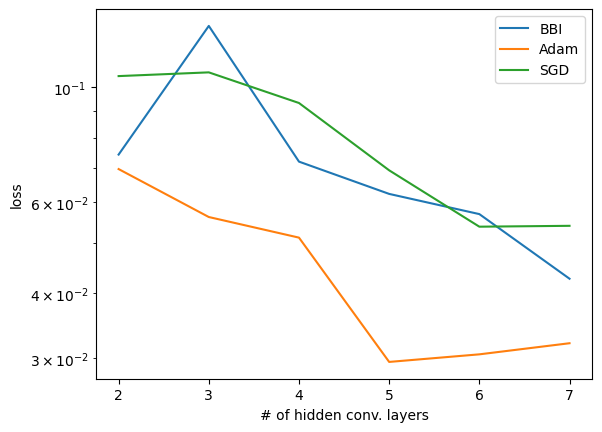

In [21]:
t = np.arange(2, 8)

sns.lineplot(y=test_loss_BBI, x=t, label='BBI')
sns.lineplot(y=test_loss_Adam, x=t, label='Adam')
sns.lineplot(y=test_loss_SGD, x=t, label='SGD')
plt.yscale('log')

# plt.title('Comparing performance of different architeture.')
plt.xlabel('# of hidden conv. layers')
plt.ylabel('loss')

plt.legend()
plt.show()

## Learning Rate Scaling with Width